In [55]:
from finance_utils.electrical.china.spot.discrete.probabilistic_forecast import DiscreteSpot,ProbabilisticDiscreteCurve
from finance_utils.electrical.china.spot.discrete.testback import TestBack
from finance_utils.electrical.china.spot.rule.recycle import SampleRecycle
import numpy

In [56]:
from data_utils.stochastic_utils.distributions.baseclass import ABCDistribution
from data_utils.stochastic_utils.distributions.basic_distributions import NormalDistribution

In [57]:
dayahead = ProbabilisticDiscreteCurve([
    NormalDistribution(200, 9),
    NormalDistribution(201, 8),
    NormalDistribution(203, 7),
    NormalDistribution(102, 6),
])

realtime = ProbabilisticDiscreteCurve([
    NormalDistribution(200 * 1.5, 20),
    NormalDistribution(201 * 1.1, 21),
    NormalDistribution(203 * 1.2, 22),
    NormalDistribution(102 * 0.5, 53),
])

quantity = ProbabilisticDiscreteCurve([
    NormalDistribution(10, 5),
    NormalDistribution(9, 3),
    NormalDistribution(15, 1),
    NormalDistribution(25, 2),
])

spot = DiscreteSpot(dayahead, realtime, quantity)

In [58]:
from matplotlib import pyplot

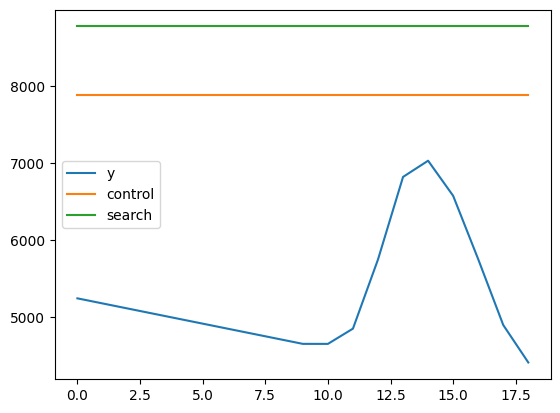

In [59]:
trigger_rate = 0.09
punishment_rate = 0.5

In [60]:
testback = TestBack(spot.random_sample(n=50, epoch=50, use_random=True))

submitt_control = spot.quantity.value_list



In [73]:
submitt_test = testback.continuous_random_grid_search(
    spot.quantity.value_list, delta_min=-20, delta_max=20, epoch=20, rounds=20, submitted_min=0, 
    submitted_max=30, recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate)[-1][0]
submitt_test2 = testback.random_grid_search(
    submitted_list= spot.quantity.value_list, 
    delta_min=-20, 
    delta_max=20, 
    epoch=400, 
    submitted_min=0, 
    submitted_max=30, 
    recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate
)[0]
submitt_test3 = testback.differential_evolution__search(
    spot.quantity.value_list,
    delta_min=-20, 
    delta_max=20,
    submitted_min=0, 
    submitted_max=30,
    recycle=SampleRecycle, 
    trigger_rate=trigger_rate,  
    punishment_rate=punishment_rate
)
submitt_test4 = spot.differential_evolution__search(
    spot.quantity.value_list,
    delta_min=-20, 
    delta_max=20,
    submitted_min=0, 
    submitted_max=30,
    recycle=SampleRecycle, 
    trigger_rate=trigger_rate,  
    punishment_rate=punishment_rate
)
print(spot.quantity.value_list)
print([submitt_test3[0].tolist(), submitt_test3[1]])
print([submitt_test4[0].tolist(), submitt_test4[1]])
print(submitt_test)
print(submitt_test2)

[10, 9, 15, 25]
[[0.09612244776752732, 28.52712224145131, 1.5706796679532253, 29.95359612104579], 9225.032881499563]
[[0.07163599210993254, 22.775298002174615, 1.2486623547245603, 29.59519809558703], 10912.612322218418]
[0, 30.0, 0, 30.0]
[0, 21.857898398722064, 8.559030690318664, 30]


In [62]:
noise_dayahead = ProbabilisticDiscreteCurve([
    NormalDistribution(200, 9 * 1.5),
    NormalDistribution(201, 8 * 1.5),
    NormalDistribution(203, 7 * 1.5),
    NormalDistribution(102, 6 * 1.5),
])

noise_realtime = ProbabilisticDiscreteCurve([
    NormalDistribution(200 * 1.2, 20 * 1.5),
    NormalDistribution(201 * 1.1, 21 * 1.5),
    NormalDistribution(203 * 1.2, 22 * 1.5),
    NormalDistribution(102 * 0.5, 53 * 1.5),
])

noise_quantity = ProbabilisticDiscreteCurve([
    NormalDistribution(10, 5 * 1.5),
    NormalDistribution(9, 3 * 1.5),
    NormalDistribution(15, 1 * 1.5),
    NormalDistribution(25, 2 * 1.5),
])
noise_spot = DiscreteSpot(dayahead, realtime, quantity)

In [74]:
rec = []
for _ in range(100):
    # temp_testback = TestBack(noise_spot.random_sample(n=50, epoch=50, use_random=True))
    temp_testback = TestBack(spot.random_sample(n=50, epoch=50, use_random=True))
    rec.append([
        temp_testback.testback_yield(submitt_control, recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).mean(),
        temp_testback.testback_yield(submitt_test, recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).mean(),
        temp_testback.testback_yield(submitt_test3[0], recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).mean(),
        temp_testback.testback_yield(submitt_test4[0], recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).mean(),
    ])
print(rec)

[[8073.72154263859, 9725.154869923606, 9679.875777808007, 7260.342430644328], [8206.227478796773, 9160.170740824058, 9127.30269595965, 7820.254201754788], [7854.986575664055, 8906.559345495743, 8871.413671100281, 8115.255909556062], [7810.9080489344915, 9015.535069904465, 8765.49584712292, 7550.903874680567], [7778.302906328204, 9235.439565756968, 9194.52550283471, 6892.3069904412], [8001.353256072565, 8661.27466682656, 8747.36724584088, 7602.2444435263305], [7587.7049084683, 8602.89106623336, 8562.890418247338, 7822.370649097865], [8147.43656284343, 9615.516335600067, 9583.76628947374, 7747.436485883242], [7943.167686459609, 8868.64992954783, 8822.521117097098, 7765.503006089183], [7576.974170631326, 9037.4308791258, 8996.071975632847, 8083.049158405762], [7624.2451517100435, 9275.115851086353, 9235.281012994832, 7460.673080918815], [7153.571323023591, 8293.098625255789, 8257.731764022601, 7512.520102376193], [7619.333732181138, 9013.310921104534, 8973.295190483093, 7757.881397624344]

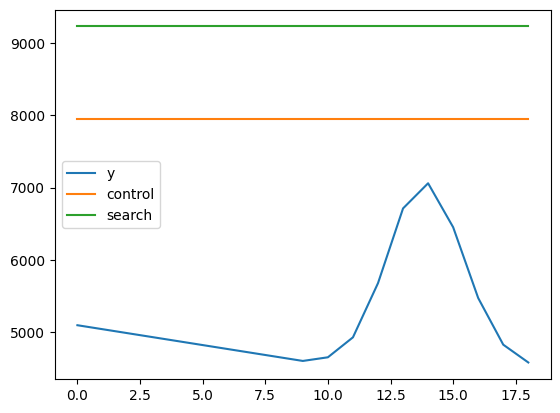

In [75]:
y_hat = [
    numpy.mean(
        testback.testback_yield([i] * 4, recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).yield_curve
    ) for i in range(1,20)
]
y_control = [
    numpy.mean(
        testback.testback_yield(spot.quantity.value_list, recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).yield_curve
    ) for i in range(1,20)
]
y_search = [
    numpy.mean(
        testback.testback_yield(submitt_test3[0],
                                recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).yield_curve
    ) for i in range(1,20)
]
# pyplot.plot(y)
pyplot.plot(y_hat)
pyplot.plot(y_control)
pyplot.plot(y_search)
pyplot.legend(["y","control","search"])
pyplot.show()